HW4 Tardigrades.

# 1. Obtaining data 

1.1 Genomic: `wget -o data/Tardi_assebled_genome.fna.gz http://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001/949/185/GCA_001949185.1_Rvar_4.0/GCA_001949185.1_Rvar_4.0_genomic.fna.gz` \
1.2 AUGUSTUS results: https://drive.google.com/file/d/1hCEywBlqNzTrIpQsZTVuZk1S9qKzqQAq/view?usp=sharing \
1.3 GFF: https://drive.google.com/file/d/12ShwrgLkvJIYQV2p1UlXklmxSOOxyxj4/view?usp=sharing \
1.4 getAnnoFasta.pl script: http://augustus.gobics.de/binaries/scripts/getAnnoFasta.pl \
1.5 Tandem Mass Spectrometry results: https://disk.yandex.ru/d/xJqQMGX77Xueqg \

# 2. Get number of obtained proteins 

`grep ">" data/augustus.whole.aa | wc -l`
-> 16435 \
2.1 To narrow down the amount of genes we can look for those which take their place in a nucleus, thus having a NLS (Nuclear Localization Signals). Classical NLS (cNLS): This type of signal is recognized by importin α and importin β proteins. The classical NLS is usually a short stretch of basic amino acids, such as lysine or arginine. The consensus sequence for classical NLS is typically (K/R)4-5(K/R)X(K/R).

# 3. Do a local alignment-based search 

3.1 *SP*Option a*SP* \
`conda install -c bioconda blast` \
`makeblastdb -in data/augustus.whole.aa -dbtype prot  -out data/blastp_tardigrade_protein_db` \
`blastp -db data/blastp_tardigrade_protein_db -query data/peptides.fa -outfmt 6 -out data/blastp_tardigrade_filtered_proteins` \
Column names format 6: qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore \
3.2 *SP*Option b*SP* \
`conda install -c bioconda diamond` \
`diamond makedb --in data/augustus.whole.aa  --db data/diamond_tardigrade_protein_db` \
`diamond blastp -d data/diamond_tardigrade_protein_db.dmnd -q data/peptides.fa  -f 6 -o data/diamond_tardigrade_filtered_proteins --very-sensitive` \
Used option b. From TMS created a local database with peptides. Then blasted against fasta file with all proteins.

# 4. Localization prediction 

Get fasta's for filtered genes \
for 3a:
- unique gene names
`awk -F'\t' '{print $2}' data/blastp_tardigrade_filtered_proteins | sort -u | wc -l`
`awk -F'\t' '{print $2}' data/blastp_tardigrade_filtered_proteins | sort -u > data/blastp_unique_genes` \
- get fasta sequences from the original fasta for every unique gene name
`samtools faidx data/augustus.whole.aa`
`xargs samtools faidx data/augustus.whole.aa < data/blastp_unique_genes > data/blastp_selected_sequences.fasta` \
- get all gene names where prediction is SP
`awk -F'\t' '$2 == "SP" {print $1}' data/blastp_targetP_output_protein_type > data/blastp_targetP_selected_genes`
- get sequences for them
`xargs samtools faidx data/augustus.whole.aa < data/blastp_targetP_selected_genes > data/blastp_targetP_selected_genes.fasta`

for 3b:
4a. WoLF PSORT  (https://wolfpsort.hgc.jp/) predicts the subcellular localization of proteins. PSORT predicts cellular localization of proteins based on the presence of a signal peptide on their N-terminus. \
Results: \
g4106.t1 details E.R.: 14.5, E.R._golg: 9.5, extr: 7, golg: 3.5, lyso: 3, pero: 2, plas: 1, mito: 1 \
g12510.t1 details plas: 29, cyto: 3 \
(see pdfs) \
4b. TargetP (https://services.healthtech.dtu.dk/service.php?TargetP-2.0) also predicts the subcellular localization of eukaryotic proteins. The location assignment is based on the predicted presence of any of the N-terminal presequences: chloroplast transit peptide (cTP), mitochondrial targeting peptide (mTP) or secretory pathway signal peptide (SP). \
Results: \
(see zip and pdf)

# 5. BLAST

BLAST (https://blast.ncbi.nlm.nih.gov/Blast.cgi) protein sequences against the “UniProtKB/Swiss-Prot” database.



# 6. PFAM

We will use HMMER (web-version, https://www.ebi.ac.uk/Tools/hmmer/) to search our protein sequences against a collection of profile-HMMs for different protein domains and motifs.
Select “Search” and then select the suitable tool (in our case it is hmmscan), select the Pfam database, and submit your proteins.


Merge tables with WoLF PSORT and TargetP results

In [9]:
import os
import pandas as pd
import json

with open (os.path.join('data', 'blastp_WoLFPSORT_results'), 'r') as fp:
    wolf_results = {}
    file_content = fp.readlines()[0:]
    for line in file_content:
        line_content = line.strip().split(' ')
        wolf_results[line_content[0]] = (' ').join(line_content[2:])

wolf_results_df = pd.DataFrame(list(wolf_results.items()), columns=['Gene', 'Contents'])

targetP_df = pd.read_csv(os.path.join('data', 'blastp_selected_sequences_TargetP_results'), sep='\t', skiprows=1, header=0)
targetP_df.rename(columns={targetP_df.columns[0]: 'Gene'}, inplace=True)
# blast_results_df = pd.read_csv(os.path.join('data', 'blastp_selected_sequences_BLAST_results.csv'), 
#                                names=['query acc.ver', 'subject acc.ver', '% identity', 'alignment length', 'mismatches', 'gap opens', 'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score', '% positives'])

result_df = targetP_df.merge(wolf_results_df, how='inner', left_on='Gene', right_on='Gene')
pd.set_option('display.max_colwidth', None)
display(result_df)

# result_df['Contents'][0]

latex_code = result_df.to_latex(index=False, escape=False)
print(latex_code)

,Gene,Prediction,OTHER,SP,mTP,CS Position,Contents
0,g10513.t1,OTHER,0.999999,0.000001,0.000000,NaN,"nucl: 20, cyto_nucl: 14.5, cyto: 7, extr: 3, E.R.: 1, golg: 1"
1,g10514.t1,OTHER,0.999543,0.000349,0.000107,NaN,"nucl: 19, cyto_nucl: 15, cyto: 9, extr: 3, mito: 1"
2,g11320.t1,SP,0.000184,0.999816,0.000000,CS pos: 20-21. AYS-AG. Pr: 0.7236,"plas: 24.5, extr_plas: 16, extr: 6.5, lyso: 1"
3,g11513.t1,OTHER,0.999434,0.000401,0.000164,NaN,"cyto: 17, cyto_nucl: 12.8333, cyto_mito: 9.83333, nucl: 7.5, E.R.: 3, mito: 1.5, plas: 1, pero: 1, golg: 1"
4,g11806.t1,OTHER,0.998977,0.000887,0.000136,NaN,"nucl: 18, cyto_nucl: 11.8333, mito: 5, extr: 4, cyto: 3.5, cyto_pero: 2.66667, cysk_plas: 1"
5,g11960.t1,OTHER,0.999996,0.000002,0.000002,NaN,nucl: 32
6,g12388.t1,SP,0.000490,0.999481,0.000029,CS pos: 16-17. ASA-SS. Pr: 0.6485,"extr: 25, plas: 4, mito: 2, lyso: 1"
7,g12510.t1,OTHER,0.999738,0.000099,0.000163,NaN,"plas: 29, cyto: 3"
8,g12562.t1,SP,0.000076,0.999923,0.000001,CS pos: 16-17. SYA-AN. Pr: 0.7910,"extr: 30, lyso: 2"
9,g1285.t1,SP,0.003029,0.996798,0.000173,CS pos: 16-17. ASA-TS. Pr: 0.7127,"extr: 25, plas: 5, mito: 1, lyso: 1"


\begin{tabular}{llrrrll}
\toprule
     Gene & Prediction &    OTHER &       SP &      mTP &                       CS Position &                                                                                                   Contents \\
\midrule
g10513.t1 &      OTHER & 0.999999 & 0.000001 & 0.000000 &                               NaN &                                              nucl: 20, cyto_nucl: 14.5, cyto: 7, extr: 3, E.R.: 1, golg: 1 \\
g10514.t1 &      OTHER & 0.999543 & 0.000349 & 0.000107 &                               NaN &                                                         nucl: 19, cyto_nucl: 15, cyto: 9, extr: 3, mito: 1 \\
g11320.t1 &         SP & 0.000184 & 0.999816 & 0.000000 & CS pos: 20-21. AYS-AG. Pr: 0.7236 &                                                              plas: 24.5, extr_plas: 16, extr: 6.5, lyso: 1 \\
g11513.t1 &      OTHER & 0.999434 & 0.000401 & 0.000164 &                               NaN & cyto: 17, cyto_nucl: 12.8333, cyto_mito: 9.8333

C:\Users\Brave\AppData\Local\Temp\ipykernel_9460\348150165.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = result_df.to_latex(index=False, escape=False)


Now parse BLAST results

In [83]:
import pandas as pd

# Initialize variables to store data
current_query = None
hits_data = []

# Open the file for reading
with open(os.path.join('data', 'blastp_selected_sequences_BLAST_results'), 'r') as file:
    for line in file:
        line = line.strip()

        # Check if the line contains information about the Query
        if line.startswith('# Query:'):
            # If a new Query is encountered, save the previous Query and its hits
            if current_query is not None:
                # Append the hits data to the list
                hits_data.append({'Gene': current_query, 'Hits': hits})
            
            # Extract the new Query
            current_query = line.split(': ')[1]
            hits = []  # Reset the hits for the new Query
        
        # Check if the line contains information about a hit
        elif line.startswith('# Fields:'):
            # Skip lines until the hits start
            next(file)  # Move to the next line to get the hits

        elif not line.startswith('#') and line:  # Skip empty lines and lines starting with #
            # Split the line to extract hit information
            hit_info = line.split('\t')
            
            # Create a dictionary for the hit with all the fields
            hit = {
                'Query Acc.Ver': hit_info[0],
                'Subject Acc.Ver': hit_info[1],
                '% Identity': float(hit_info[2]),
                'Alignment Length': int(hit_info[3]),
                'Mismatches': int(hit_info[4]),
                'Gap Opens': int(hit_info[5]),
                'Q. Start': int(hit_info[6]),
                'Q. End': int(hit_info[7]),
                'S. Start': int(hit_info[8]),
                'S. End': int(hit_info[9]),
                'E-value': float(hit_info[10]),
                'Bit Score': float(hit_info[11]),
                '% Positives': float(hit_info[12])
            }
            
            # Store the hit information
            hits.append(hit)

# Create a DataFrame for the collected hits data
blast_result_df = pd.DataFrame.from_records(hits_data)

# If there are hits, normalize the "Hits" column
if not blast_result_df.empty and 'Hits' in blast_result_df.columns:
    df_hits_expanded = pd.json_normalize(blast_result_df['Hits'].explode(), sep='_')
    blast_result_df = pd.concat([blast_result_df.drop(columns=['Hits']), df_hits_expanded], axis=1)

# Display the resulting DataFrame
print(blast_result_df)



          Gene Query Acc.Ver Subject Acc.Ver  % Identity  Alignment Length  \
0    g10513.t1           NaN             NaN         NaN               NaN   
1    g10514.t1           NaN             NaN         NaN               NaN   
2    g11320.t1           NaN             NaN         NaN               NaN   
3    g11513.t1     g11513.t1        Q32PH0.1      28.607             811.0   
4    g11806.t1     g11513.t1        Q96Q05.2      27.039             932.0   
..         ...           ...             ...         ...               ...   
899        NaN      g8100.t1        O67791.1      24.000             300.0   
900        NaN      g8100.t1        Q8FAG5.1      24.232             293.0   
901        NaN      g8100.t1        P10497.2      38.462              52.0   
902        NaN      g8100.t1        Q45499.1      20.379             211.0   
903        NaN      g8100.t1        P46726.2      39.655              58.0   

     Mismatches  Gap Opens  Q. Start  Q. End  S. Start  S. End 

Merge all results together. Take only the smallest e-value for BLAST results

In [90]:

df_min_evalue = df_result.groupby('Gene')['E-value'].min()

print(df_min_evalue)
# blast_result_df_top_eval = blast_result_df.groupby('Gene').
# result_df = result_df.merge(blast_result_df_top_eval, how='inner', left_on='Gene', right_on='Gene')

Gene
g10513.t1             NaN
g10514.t1             NaN
g11320.t1             NaN
g11513.t1    6.640000e-83
g11806.t1    3.590000e-81
g11960.t1    4.550000e-80
g12388.t1    2.940000e-77
g12510.t1    8.340000e-05
g12562.t1    5.490000e-51
g1285.t1     1.700000e-09
g13530.t1    2.650000e-19
g14472.t1    3.120000e-14
g15153.t1             NaN
g15484.t1    6.160000e-98
g16318.t1    2.390000e-93
g16368.t1    1.090000e-90
g2203.t1     2.300000e-89
g3428.t1     6.240000e-88
g3679.t1     2.160000e-82
g4106.t1     3.200000e-82
g4970.t1     1.880000e-81
g5237.t1     3.740000e-46
g5443.t1     1.070000e-36
g5467.t1     1.930000e-29
g5502.t1     2.020000e-29
g5503.t1     1.000000e-03
g5510.t1     2.750000e-27
g5616.t1     1.980000e-21
g5641.t1     7.430000e-20
g5927.t1     2.510000e-19
g702.t1      6.070000e-19
g7861.t1     4.800000e-02
g8100.t1     7.790000e-19
Name: E-value, dtype: float64


PFAM predictions

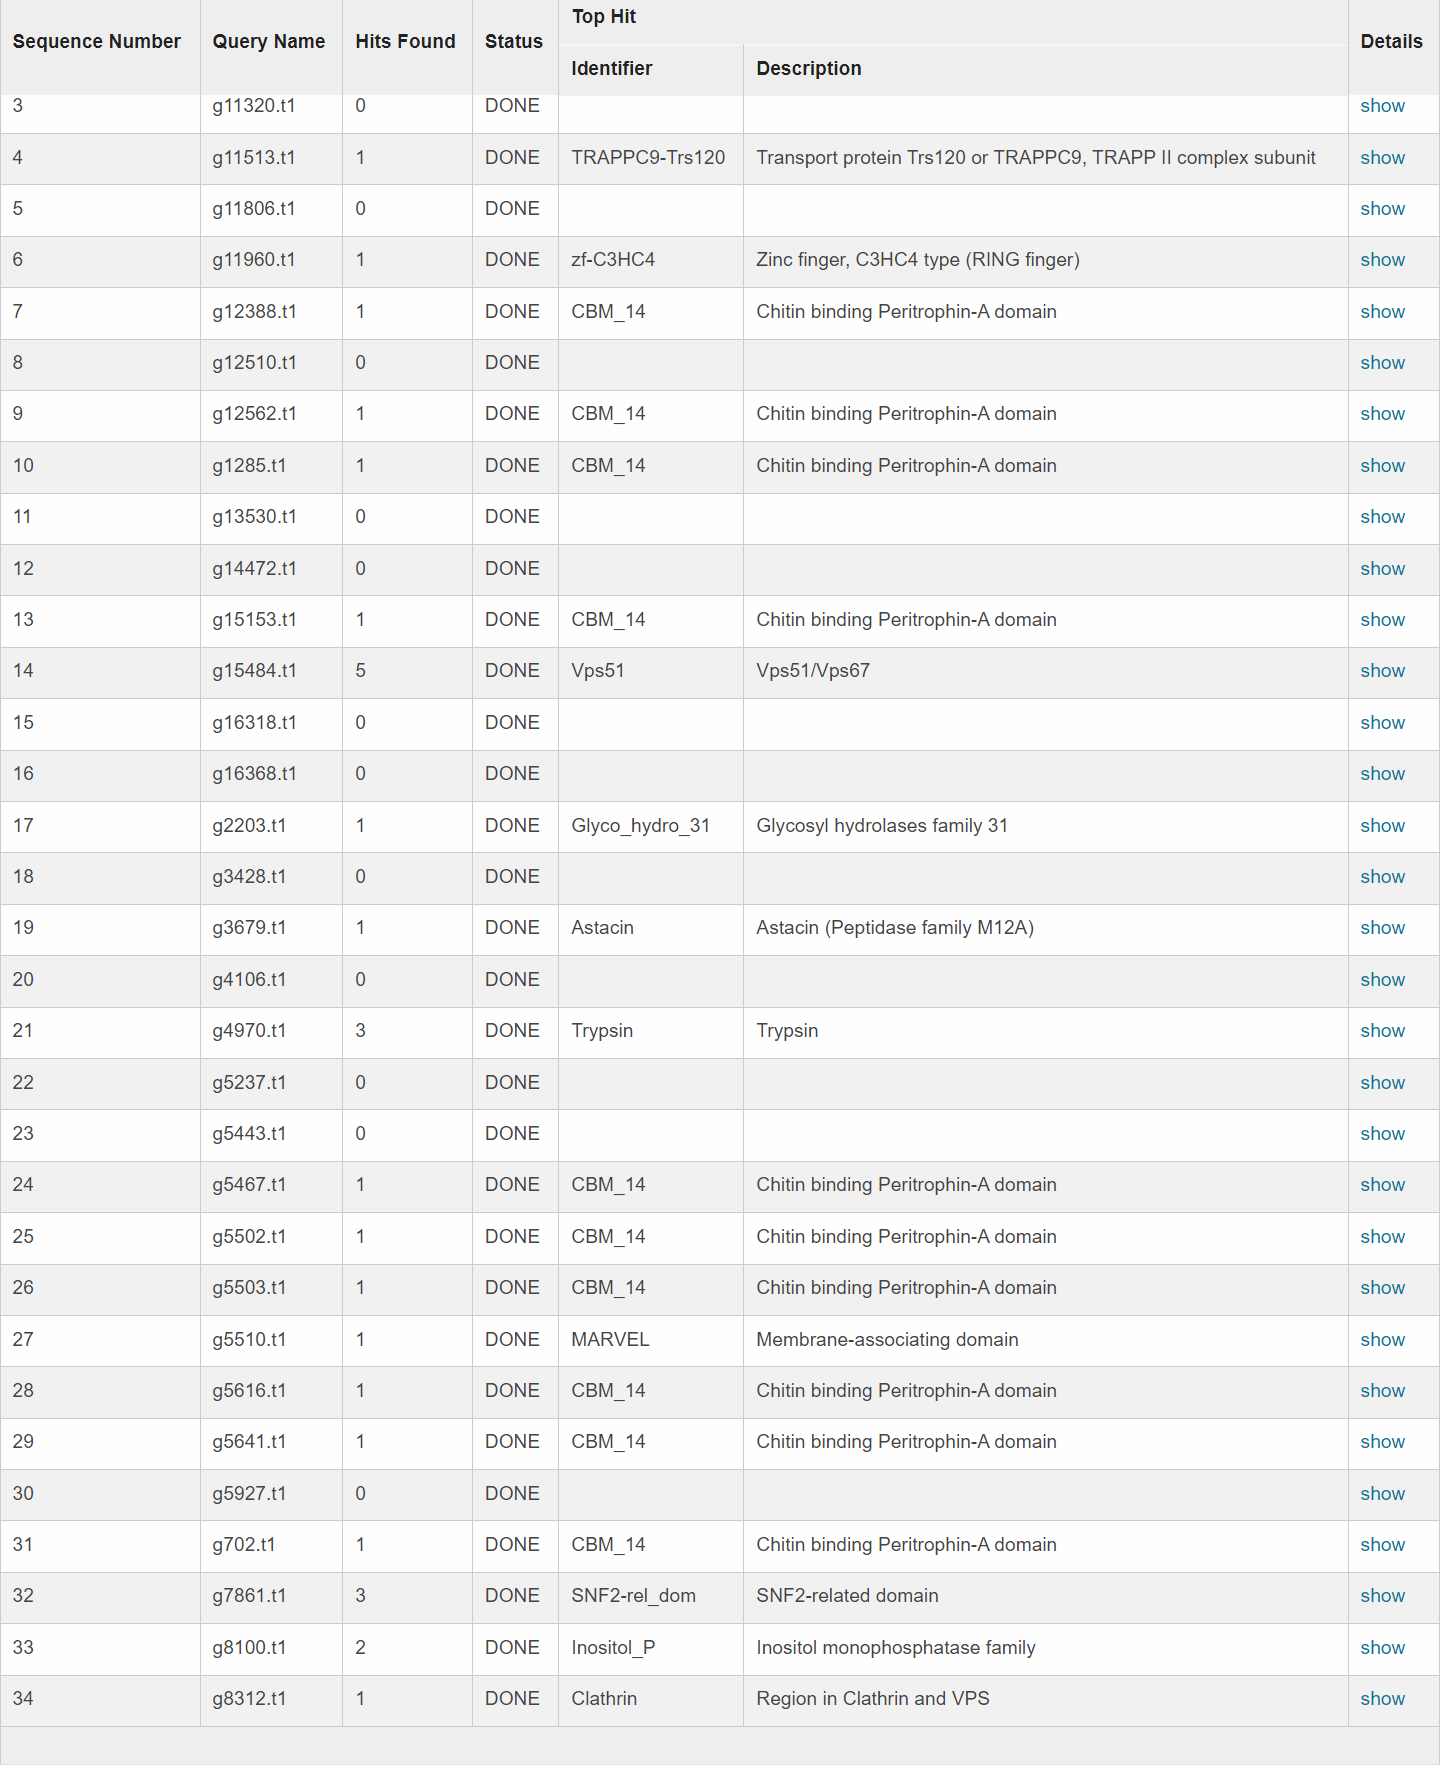